In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from dask.diagnostics import ProgressBar
plt.style.use('/home/aos/kyan/.config/matplotlib/esm2m.mplstyle')

# Load ToEs

In [2]:
#land mask data
#ESM2M
land_area_esm2m = xr.open_dataset('../data/processed/GFDL/esm2m.land_area')['land_area']
land_mask_esm2m = land_area_esm2m>0

#CESM2
land_area_cesm2 = xr.open_dataset('../data/processed/CESM2/cesm2.land_area')['__xarray_dataarray_variable__'].isel(ensemble=0)
land_mask_cesm2 = land_area_cesm2>0

In [3]:
# Population data
ds_pop_esm2m = xr.open_dataset('../data/processed/GFDL/population_regrid_esm2m_2.nc')['population']
ds_pop_esm2m = ds_pop_esm2m.where(np.isfinite(ds_pop_esm2m),0)

# Population data
ds_pop_cesm2 = xr.open_dataset('../data/processed/CESM2/population_regrid_cesm2_2.nc')['population']
ds_pop_cesm2 = ds_pop_cesm2.where(np.isfinite(ds_pop_cesm2),0)

In [4]:
#ToEs, masking out ocean
ds_toe_esm2m = xr.open_dataset('../data/processed/GFDL/hottestmonth_toes.nc').where(land_mask_esm2m,np.nan)
ds_toe_cesm2 = xr.open_dataset('../data/processed/CESM2/hottestmonth_toes.nc').where(land_mask_cesm2,np.nan)

In [50]:
#average ToE range by latitude
range_esm2m = lf.calc_range(ds_toe_esm2m)
range_cesm2 = lf.calc_range(ds_toe_cesm2)

/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Calculations

In [59]:
#Earliest mean emergence times
print(range_esm2m[0].where(range_esm2m[0]>0,np.nan).max())
print(range_cesm2[0].where(range_cesm2[0]>0,np.nan).max())

<xarray.Dataset>
Dimensions:  ()
Data variables:
    0.75     float64 41.0
    0.5      float64 27.0
<xarray.Dataset>
Dimensions:  ()
Data variables:
    0.75     float64 60.0
    0.5      float64 63.0


# Calculate ToEs

In [25]:
# Baseline data
ds_base_esm2m = xr.open_dataarray('../data/processed/GFDL/esm2m_baseline_hottestmonths.nc')
ds_base_cesm2 = xr.open_dataarray('../data/processed/CESM2/cesm2_baseline_hottestmonths.nc')

In [26]:
# Hottest months data
ds_esm2m = xr.open_dataarray('../data/processed/GFDL/esm2m_future_hottestmonths.nc')
ds_cesm2 = xr.open_dataarray('../data/processed/CESM2/cesm2_future_hottestmonths.nc')

In [27]:
# Labor reduction thresholds used to define ToE
labor_thres = [0.75,0.5]

# Calculate ToEs for all grid cells and ensemble members
ds_toe_esm2m = lf.toe_summer(ds_esm2m,ds_base_esm2m,labor_thres)
ds_toe_cesm2 = lf.toe_summer(ds_cesm2,ds_base_cesm2,labor_thres)

# Spatial Maps

/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


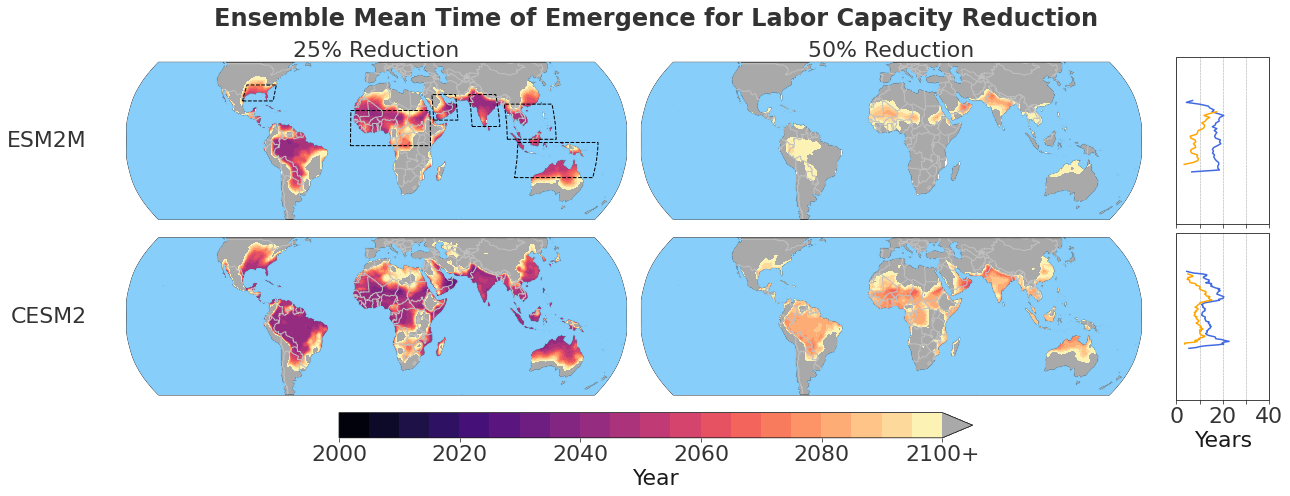

In [76]:
lf.spatial_toe(ds_toe_esm2m,ds_toe_cesm2,range_esm2m[1],range_cesm2[1],'Ensemble Mean Time of Emergence for Labor Capacity Reduction',['0.75','0.5'])
#plt.savefig('spatial_toe_esm2m.png',dpi=300)

# ToE Range

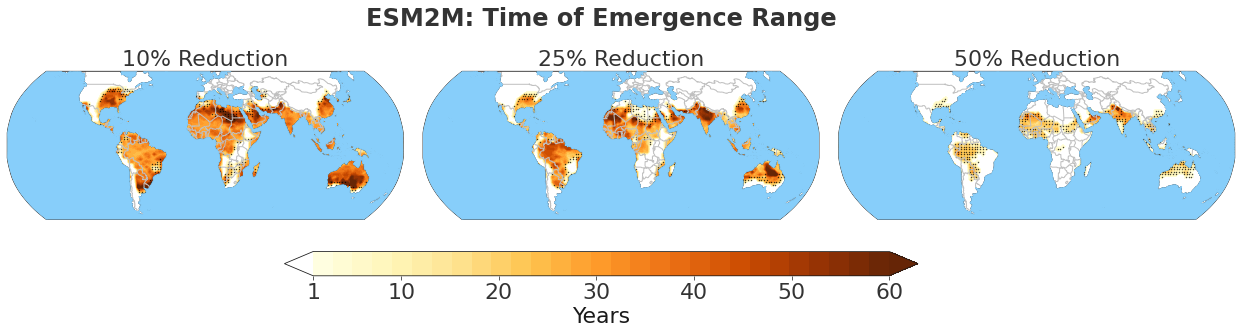

In [48]:
lf.spatial_toe_diff(ds_toe_esm2m,'ESM2M: Time of Emergence Range',['0.9','0.75','0.5'],s=0.5)
plt.savefig('toe_diff_esm2m.png',dpi=300)

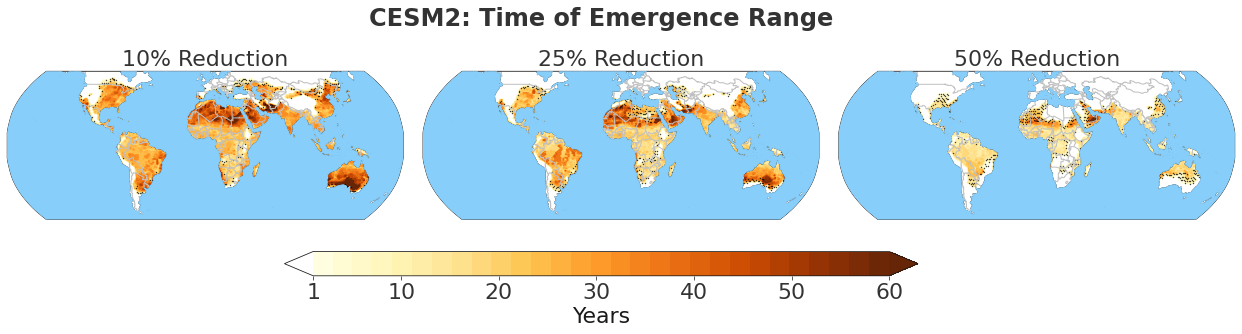

In [49]:
lf.spatial_toe_diff(ds_toe_cesm2,'CESM2: Time of Emergence Range',['0.9','0.75','0.5'],s=0.5,reduce=True)
plt.savefig('toe_diff_cesm2.png',dpi=300)

# Time Series

In [53]:
def frac_emerge_plot(ds_toe_esm2m,ds_toe_cesm2,ds_pop_esm2m,ds_pop_cesm2,title,ax,ylabel=False,xlabel=False):
    '''Plot a single time series of fraction of population emerged'''
    
    thres = ['0.75','0.5']
    
    # Calculate fraction of population that has emerged
    ds_frac_esm2m = lf.frac_emerge(ds_toe_esm2m,ds_pop_esm2m)/ds_pop_esm2m.sum(['lat','lon'])
    ds_frac_cesm2 = lf.frac_emerge(ds_toe_cesm2,ds_pop_cesm2)/ds_pop_cesm2.sum(['lat','lon'])

    # Thresholds for ESM2M
    # Plot ensemble envelope (x,y_min,y_max)
    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m[thres[0]].min(dim='ensemble'),ds_frac_esm2m[thres[0]].max(dim='ensemble'),alpha=0.15,color='royalblue')
    ds_frac_esm2m[thres[0]].mean(dim='ensemble').plot(ax=ax,color='royalblue',linewidth=3)

    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m[thres[1]].min(dim='ensemble'),ds_frac_esm2m[thres[1]].max(dim='ensemble'),alpha=0.15,color='orange')
    ds_frac_esm2m[thres[1]].mean(dim='ensemble').plot(ax=ax,color='orange',linewidth=3)

    # Thresholds for CESM2
    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2[thres[0]].min(dim='ensemble'),ds_frac_cesm2[thres[0]].max(dim='ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='royalblue',linewidth=1.5)
    ds_frac_cesm2[thres[0]].mean(dim='ensemble').plot(ax=ax,color='royalblue',linestyle='dashed',linewidth=3)

    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2[thres[1]].min(dim='ensemble'),ds_frac_cesm2[thres[1]].max(dim='ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='orange',linewidth=1.5)
    ds_frac_cesm2[thres[1]].mean(dim='ensemble').plot(ax=ax,color='orange',linestyle='dashed',linewidth=3)
    
    # Set labels, limits, title
    if xlabel:
        ax.set_xlabel('Year',fontsize=22,fontweight='bold')
    else:
        ax.set_xlabel(None)
    if ylabel:
        ax.set_ylabel('Fraction of Population',fontsize=22,fontweight='bold')
    else:
        ax.set_ylabel(None)
    ax.set_ylim([0,1])
    ax.set_xlim([2010,2100])
    ax.set_xticks(np.linspace(2020,2100,5))
    ax.set_title(title,fontsize=26,fontweight='bold')

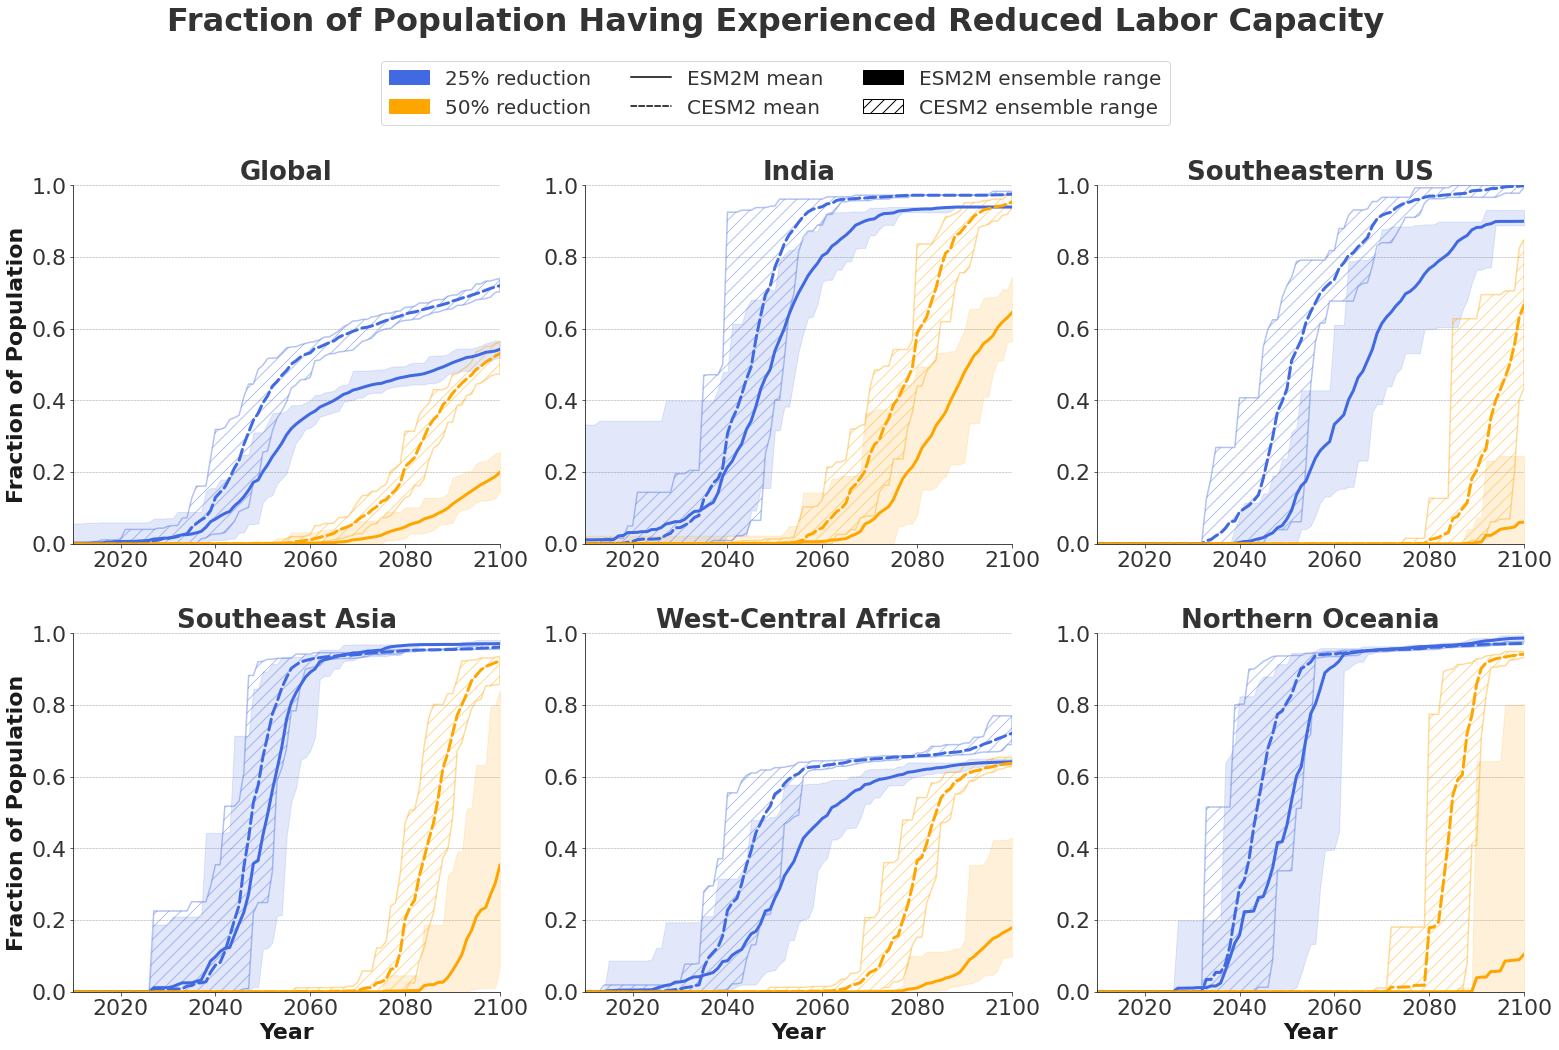

In [54]:
# Regions to plot
regions = ['Global','India','Southeastern US','Southeast Asia','West-Central Africa','Northern Oceania']

# Create figure and axes
fig, axs = plt.subplots(figsize=(26,16),nrows=2,ncols=3)

# Running counter to determine axis
index = 0

# Loop through regions
for region in regions:
    # Get correct axis
    ax = axs[int(index/3)][index%3]
    
    # Get ToE and population data for region
    toe_esm2m = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    pop_esm2m = lf.slice_region(ds_pop_esm2m,region,'GFDL')
    toe_cesm2 = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    pop_cesm2 = lf.slice_region(ds_pop_cesm2,region,'CESM2')
    
    # Call function to plot for this region
    xlabel = False
    ylabel = False
    if index>2:
        xlabel = True
    if (index%3)== 0:
        ylabel = True
    frac_emerge_plot(toe_esm2m,toe_cesm2,pop_esm2m,pop_cesm2,region,ax,ylabel,xlabel)
    index+=1

# Set legend
blue_patch = mpatches.Patch(color='royalblue', label='25% reduction')
orange_patch = mpatches.Patch(color='orange', label='50% reduction')

solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='ESM2M mean')
dot_line = mlines.Line2D([], [], color='black', linestyle='dashed', label='CESM2 mean')

solid_patch = mpatches.Patch(color='black', label='ESM2M ensemble range')
hatch_patch = mpatches.Patch(fill=False, hatch='//', color='black', label='CESM2 ensemble range')

# Create axis at top for legend
fig.subplots_adjust(top=0.825)
legend_ax = fig.add_axes([0.3, 0.865, 0.4, 0.08])
legend_ax.legend(handles=[blue_patch,orange_patch,solid_line,dot_line,solid_patch,hatch_patch],ncol=3,loc='center');

# Make legend axis markings invisible 
legend_ax.set_frame_on(False)
legend_ax.grid(False)
legend_ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

# Make sure plots don't overlap
fig.subplots_adjust(wspace=.2,hspace=.25)
fig.suptitle('Fraction of Population Having Experienced Reduced Labor Capacity',fontsize=32,fontweight='bold');
#plt.savefig('timeseries_emerge.png',dpi=200)

# Event Plot

In [77]:
regions = ['Middle East','Northern Oceania','West-Central Africa','Southeast Asia','Southeastern US','India']
thres = ['0.75','0.5']

esm2m_1 = xr.Dataset()
esm2m_2 = xr.Dataset()

for region in regions:
    ds_region = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    esm2m_1[region] = ds_region[thres[0]].weighted(ds_pop_esm2m).mean(['lat','lon'])
    esm2m_2[region] = ds_region[thres[1]].weighted(ds_pop_esm2m).mean(['lat','lon'])

esm2m_1 = esm2m_1.to_array(dim='region')
esm2m_2 = esm2m_2.to_array(dim='region')

In [78]:
cesm2_1 = xr.Dataset()
cesm2_2 = xr.Dataset()

for region in regions:
    ds_region = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    cesm2_1[region] = ds_region[thres[0]].weighted(ds_pop_cesm2).mean(['lat','lon'])
    cesm2_2[region] = ds_region[thres[1]].weighted(ds_pop_cesm2).mean(['lat','lon'])
    
cesm2_1 = cesm2_1.to_array(dim='region')
cesm2_2 = cesm2_2.to_array(dim='region')

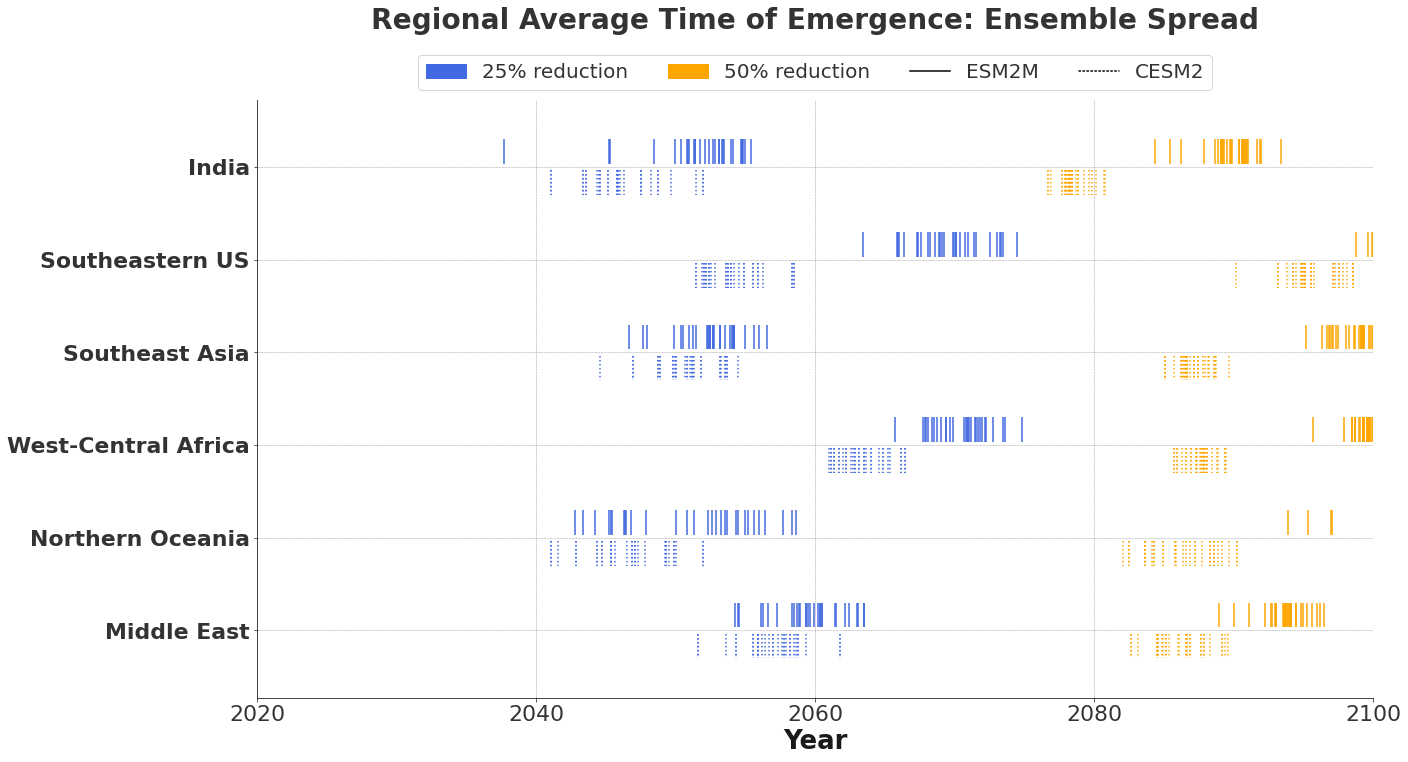

In [79]:
fig,ax=plt.subplots(figsize=(20,11))

ax.eventplot(cesm2_1,orientation='horizontal',colors='royalblue',linelengths=0.8,linestyles='dotted',lineoffsets=[1,4,7,10,13,16]);
ax.eventplot(cesm2_2,orientation='horizontal',colors='orange',linelengths=0.8,linestyles='dotted',lineoffsets=[1,4,7,10,13,16]);

ax.eventplot(esm2m_1,orientation='horizontal',colors='royalblue',linelengths=0.8,lineoffsets=[2,5,8,11,14,17]);
ax.eventplot(esm2m_2,orientation='horizontal',colors='orange',linelengths=0.8,lineoffsets=[2,5,8,11,14,17]);

locs = np.arange(1.5,19.5,3)
ax.set_yticks(locs)
ax.set_yticklabels(regions,fontweight='bold');
ax.set_xlim([2020,2100]);
ax.set_xticks(range(2020,2120,20))
ax.set_xlabel('Year',fontsize=26,fontweight='bold')
ax.set_title('Regional Average Time of Emergence: Ensemble Spread\n\n',fontsize=28,fontweight='bold');
ax.grid(axis='x')

# Set legend
blue_patch = mpatches.Patch(color='royalblue', label='25% reduction')
orange_patch = mpatches.Patch(color='orange', label='50% reduction')

solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='ESM2M')
dot_line = mlines.Line2D([], [], color='black', linestyle='dotted', label='CESM2')

ax.legend(handles=[blue_patch,orange_patch,solid_line,dot_line],ncol=5,fancybox=True,loc='lower center',bbox_to_anchor=(0.5,1));
#plt.savefig('barcode_toe.png',dpi=300)

# Old (w/ 10% threshold)

In [ ]:
def frac_emerge_plot(ds_toe_esm2m,ds_toe_cesm2,ds_pop_esm2m,ds_pop_cesm2,title,ax,ylabel=False,xlabel=False):
    '''Plot a single time series of fraction of population emerged'''
    
    thres = ['0.9','0.75','0.5']
    
    # Calculate fraction of population that has emerged
    ds_frac_esm2m = lf.frac_emerge(ds_toe_esm2m,ds_pop_esm2m)/ds_pop_esm2m.sum(['lat','lon'])
    ds_frac_cesm2 = lf.frac_emerge(ds_toe_cesm2,ds_pop_cesm2)/ds_pop_cesm2.sum(['lat','lon'])

    # Thresholds for ESM2M
    # Plot ensemble envelope (x,y_min,y_max)
    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m[thres[0]].min(dim='ensemble'),ds_frac_esm2m[thres[0]].max(dim='ensemble'),alpha=0.15,color='royalblue')
    # Plot ensemble mean
    ds_frac_esm2m[thres[0]].mean(dim='ensemble').plot(ax=ax,color='royalblue',linewidth=3)

    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m[thres[1]].min(dim='ensemble'),ds_frac_esm2m[thres[1]].max(dim='ensemble'),alpha=0.15,color='forestgreen')
    ds_frac_esm2m[thres[1]].mean(dim='ensemble').plot(ax=ax,color='forestgreen',linewidth=3)

    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m[thres[2]].min(dim='ensemble'),ds_frac_esm2m[thres[2]].max(dim='ensemble'),alpha=0.15,color='orange')
    ds_frac_esm2m[thres[2]].mean(dim='ensemble').plot(ax=ax,color='orange',linewidth=3)

    # Thresholds for CESM2
    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2[thres[0]].min(dim='ensemble'),ds_frac_cesm2[thres[0]].max(dim='ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='royalblue',linewidth=1.5)
    ds_frac_cesm2[thres[0]].mean(dim='ensemble').plot(ax=ax,color='royalblue',linestyle='dashed',linewidth=3)

    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2[thres[1]].min(dim='ensemble'),ds_frac_cesm2[thres[1]].max(dim='ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='forestgreen',linewidth=1.5)
    ds_frac_cesm2[thres[1]].mean(dim='ensemble').plot(ax=ax,color='forestgreen',linestyle='dashed',linewidth=3)

    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2[thres[2]].min(dim='ensemble'),ds_frac_cesm2[thres[2]].max(dim='ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='orange',linewidth=1.5)
    ds_frac_cesm2[thres[2]].mean(dim='ensemble').plot(ax=ax,color='orange',linestyle='dashed',linewidth=3)
    
    # Set labels, limits, title
    if xlabel:
        ax.set_xlabel('Year',fontsize=22,fontweight='bold')
    else:
        ax.set_xlabel(None)
    if ylabel:
        ax.set_ylabel('Fraction of Population',fontsize=22,fontweight='bold')
    else:
        ax.set_ylabel(None)
    ax.set_ylim([0,1])
    ax.set_xlim([2010,2100])
    ax.set_xticks(np.linspace(2020,2100,5))
    ax.set_title(title,fontsize=26,fontweight='bold')

In [ ]:
# Regions to plot
regions = ['Global','India','Northern South America','Southeast Asia','West-Central Africa','Northern Oceania']

# Create figure and axes
fig, axs = plt.subplots(figsize=(26,16),nrows=2,ncols=3)

# Running counter to determine axis
index = 0

# Loop through regions
for region in regions:
    # Get correct axis
    ax = axs[int(index/3)][index%3]
    
    # Get ToE and population data for region
    toe_esm2m = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    pop_esm2m = lf.slice_region(ds_pop_esm2m,region,'GFDL')
    toe_cesm2 = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    pop_cesm2 = lf.slice_region(ds_pop_cesm2,region,'CESM2')
    
    # Call function to plot for this region
    xlabel = False
    ylabel = False
    if index>2:
        xlabel = True
    if (index%3)== 0:
        ylabel = True
    frac_emerge_plot(toe_esm2m,toe_cesm2,pop_esm2m,pop_cesm2,region,ax,ylabel,xlabel)
    index+=1

# Set legend
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='forestgreen', label='25% reduction')
orange_patch = mpatches.Patch(color='orange', label='50% reduction')

solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='ESM2M mean')
dot_line = mlines.Line2D([], [], color='black', linestyle='dashed', label='CESM2 mean')

solid_patch = mpatches.Patch(color='black', label='ESM2M ensemble range')
hatch_patch = mpatches.Patch(fill=False, hatch='//', color='black', label='CESM2 ensemble range')

# Create axis at top for legend
fig.subplots_adjust(top=0.825)
legend_ax = fig.add_axes([0.3, 0.865, 0.4, 0.08])
legend_ax.legend(handles=[blue_patch,green_patch,orange_patch,solid_line,dot_line,solid_patch,hatch_patch],ncol=3,loc='center');

# Make legend axis markings invisible 
legend_ax.set_frame_on(False)
legend_ax.grid(False)
legend_ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

# Make sure plots don't overlap
fig.subplots_adjust(wspace=.2,hspace=.25)
fig.suptitle('Fraction of Population Having Experienced Reduced Labor Capacity',fontsize=32,fontweight='bold');
plt.savefig('timeseries_emerge.png',dpi=200)

In [ ]:
regions = ['India','Northern South America','Southeast Asia','West-Central Africa','Northern Oceania']
thres = ['0.9','0.75','0.5']

esm2m_1 = xr.Dataset()
esm2m_2 = xr.Dataset()
esm2m_3 = xr.Dataset()

for region in regions:
    ds_region = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    esm2m_1[region] = ds_region[thres[0]].weighted(ds_pop_esm2m).mean(['lat','lon'])
    esm2m_2[region] = ds_region[thres[1]].weighted(ds_pop_esm2m).mean(['lat','lon'])
    esm2m_3[region] = ds_region[thres[2]].weighted(ds_pop_esm2m).mean(['lat','lon'])

esm2m_1 = esm2m_1.to_array(dim='region')
esm2m_2 = esm2m_2.to_array(dim='region')
esm2m_3 = esm2m_3.to_array(dim='region')

In [ ]:
cesm2_1 = xr.Dataset()
cesm2_2 = xr.Dataset()
cesm2_3 = xr.Dataset()

for region in regions:
    ds_region = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    cesm2_1[region] = ds_region[thres[0]].weighted(ds_pop_cesm2).mean(['lat','lon'])
    cesm2_2[region] = ds_region[thres[1]].weighted(ds_pop_cesm2).mean(['lat','lon'])
    cesm2_3[region] = ds_region[thres[2]].weighted(ds_pop_cesm2).mean(['lat','lon'])
    
cesm2_1 = cesm2_1.to_array(dim='region')
cesm2_2 = cesm2_2.to_array(dim='region')
cesm2_3 = cesm2_3.to_array(dim='region')

In [ ]:
fig,ax=plt.subplots(figsize=(20,11))
ax.eventplot(esm2m_1,orientation='vertical',colors='royalblue',linelengths=0.8,lineoffsets=[1,4,7,10,13]);
ax.eventplot(esm2m_2,orientation='vertical',colors='forestgreen',linelengths=0.8,lineoffsets=[1,4,7,10,13]);
ax.eventplot(esm2m_3,orientation='vertical',colors='orange',linelengths=0.8,lineoffsets=[1,4,7,10,13]);

ax.eventplot(cesm2_1,orientation='vertical',colors='royalblue',linelengths=0.8,linestyles='dotted',lineoffsets=[2,5,8,11,14]);
ax.eventplot(cesm2_2,orientation='vertical',colors='forestgreen',linelengths=0.8,linestyles='dotted',lineoffsets=[2,5,8,11,14]);
ax.eventplot(cesm2_3,orientation='vertical',colors='orange',linelengths=0.8,linestyles='dotted',lineoffsets=[2,5,8,11,14]);

locs = np.arange(1.5,16.5,3)
ax.set_xticks(locs)
ax.set_xticklabels(['India','Northern\nSouth America','Southeast Asia','West-Central\nAfrica','Northern Oceania'],fontweight='bold');
ax.set_ylim([2000,2100]);
ax.set_ylabel('Year',fontsize=26,fontweight='bold')
ax.set_title('Regional Average Time of Emergence: Ensemble Spread\n\n',fontsize=28,fontweight='bold');

# Set legend
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='forestgreen', label='25% reduction')
orange_patch = mpatches.Patch(color='orange', label='50% reduction')

solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='ESM2M')
dot_line = mlines.Line2D([], [], color='black', linestyle='dotted', label='CESM2')

ax.legend(handles=[blue_patch,green_patch,orange_patch,solid_line,dot_line],ncol=5,fancybox=True,loc='lower center',bbox_to_anchor=(0.5,1));
plt.savefig('barcode_toe.png',dpi=300)